# 02_bandit_sim.ipynb

Bayesian bandit simulation over a menu of portfolio templates using Normal–Inverse-Gamma Thompson sampling (mean and risk-aware CVaR variants), compared against static portfolio benchmarks and SPY buy-and-hold.

## 1. Imports and data loading

Load the preprocessed return data:

- `returns_long_universe.parquet`: long-format daily returns by ticker.
- `active_universe_top20_vol_plus_SPY.parquet`: dynamic active universe per day.
- `portfolio_returns_dynamic.parquet`: precomputed daily returns for portfolio templates (EW_active, EW_top5vol, MOM_top5, LOWVOL_top5, Markowitz_static, etc.).

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams['figure.figsize'] = (10, 6)

DATA_PROCESSED = Path('../data_processed')

# Long-format returns for all tickers
returns_long = pd.read_parquet(DATA_PROCESSED / 'returns_long_universe.parquet')

# Active universe (top-K vol per date)
active_universe = pd.read_parquet(
    DATA_PROCESSED / 'active_universe_top20_vol_plus_SPY.parquet'
)

# Precomputed dynamic portfolio returns
port_returns = pd.read_parquet(DATA_PROCESSED / 'portfolio_returns_dynamic.parquet')

returns_long.head(), active_universe.head(), port_returns.head()

(        date ticker       ret
 0 2010-01-05   AAPL  0.001728
 1 2010-01-05   AMZN  0.005883
 2 2010-01-05    BAC  0.031987
 3 2010-01-05    CVX  0.007058
 4 2010-01-05    GLD -0.000911,
         date ticker  active
 0 2010-04-01   NVDA    True
 1 2010-04-01    BAC    True
 2 2010-04-01    UNH    True
 3 2010-04-01    SLV    True
 4 2010-04-01   AMZN    True,
             date         portfolio       ret
 15784 2010-01-05  Markowitz_static  0.003374
 15785 2010-01-06  Markowitz_static -0.002281
 15786 2010-01-07  Markowitz_static  0.004022
 15787 2010-01-08  Markowitz_static  0.000735
 15788 2010-01-11  Markowitz_static -0.002843)

## 2. Bandit environments

We define two environments:

- `AssetBanditEnv`: bandit over individual assets within the active universe (kept for possible extensions).
- `PortfolioBanditEnv`: bandit over portfolio templates (the main environment used in this notebook).

Each environment exposes:

- `current_date()` – the current trading date index.
- `available_arms()` – the set of arms that can be played on that date.
- `step(arm)` – returns `(date, ret, done)` for the chosen arm and advances the date index.

In [49]:
class AssetBanditEnv:
    """Bandit environment over individual assets with a dynamic active universe.

    Data assumptions:
      - returns_long: ['date', 'ticker', 'ret']
      - active_universe: ['date', 'ticker']
    """

    def __init__(self, returns_long: pd.DataFrame, active_universe: pd.DataFrame):
        df = returns_long.merge(
            active_universe[['date', 'ticker']],
            on=['date', 'ticker'],
            how='inner',
        )
        df = df.sort_values('date')

        self.data = df
        self.dates = df['date'].unique()
        self.current_idx = 0

    def reset(self):
        self.current_idx = 0

    def current_date(self):
        return self.dates[self.current_idx]

    def available_arms(self):
        d = self.current_date()
        return (
            self.data.loc[self.data['date'] == d, 'ticker']
            .unique()
            .tolist()
        )

    def step(self, chosen_ticker: str):
        d = self.current_date()
        mask = (self.data['date'] == d) & (self.data['ticker'] == chosen_ticker)
        r = float(self.data.loc[mask, 'ret'].iloc[0])

        self.current_idx += 1
        done = self.current_idx >= len(self.dates)

        return d, r, done


class PortfolioBanditEnv:
    def __init__(self, port_returns: pd.DataFrame):
        df = port_returns.sort_values(['date', 'portfolio'])
        self.data = df
        self.dates = df['date'].unique()
        self.current_idx = 0

    def reset(self):
        self.current_idx = 0

    def current_date(self):
        return self.dates[self.current_idx]

    def available_arms(self):
        d = self.current_date()
        return (
            self.data.loc[self.data['date'] == d, 'portfolio']
            .unique()
            .tolist()
        )

    def step(self, portfolio_name: str):
        d = self.current_date()
        mask = (self.data['date'] == d) & (self.data['portfolio'] == portfolio_name)

        if not mask.any():
            raise ValueError(
                f"No row found for date={d} and portfolio={portfolio_name}. "
                f"Available arms on that date are: "
                f"{self.data.loc[self.data['date'] == d, 'portfolio'].unique().tolist()}"
            )

        r = float(self.data.loc[mask, 'ret'].iloc[0])

        self.current_idx += 1
        done = self.current_idx >= len(self.dates)
        return d, r, done


asset_env = AssetBanditEnv(returns_long, active_universe)
port_env = PortfolioBanditEnv(port_returns)

asset_env.current_date(), asset_env.available_arms()[:5], port_env.available_arms()

(Timestamp('2010-04-01 00:00:00'),
 ['AAPL', 'XOM', 'WFC', 'UNH', 'SPY'],
 ['Markowitz_static'])

## 3. Performance statistics helper

Define a utility to compute annualised mean, volatility, Sharpe ratio, Sortino ratio, and maximum drawdown for a given return series.

In [50]:
def perf_stats(df: pd.DataFrame, ret_col: str = 'ret', freq: int = 252):
    r = df[ret_col].dropna()

    ann_mu = r.mean() * freq
    ann_sigma = r.std() * np.sqrt(freq)
    sharpe = ann_mu / ann_sigma if ann_sigma > 0 else np.nan

    downside = r[r < 0]
    if len(downside) > 1:
        downside_sigma = downside.std() * np.sqrt(freq)
        sortino = ann_mu / downside_sigma if downside_sigma > 0 else np.nan
    else:
        sortino = np.nan

    equity = (1.0 + r).cumprod()
    peak = equity.cummax()
    dd = equity / peak - 1.0
    max_dd = dd.min()

    return {
        'ann_mu': ann_mu,
        'ann_sigma': ann_sigma,
        'sharpe': sharpe,
        'sortino': sortino,
        'max_dd': max_dd,
    }

## 4. Simulation helpers

We now define two drivers:

- `run_portfolio_benchmark`: deterministic benchmark that always holds a single portfolio template.
- `run_portfolio_bandit`: bandit loop over portfolio templates, given an environment and policy.

In [51]:
def run_portfolio_benchmark(port_returns: pd.DataFrame,
                            portfolio_name: str,
                            label: str = None):
    if label is None:
        label = portfolio_name

    df = (
        port_returns
        .loc[port_returns['portfolio'] == portfolio_name]
        .sort_values('date')
        .copy()
    )
    if df.empty:
        raise ValueError(f"No rows found for portfolio '{portfolio_name}' in port_returns.")

    df['wealth'] = (1.0 + df['ret']).cumprod()
    df['strategy'] = label
    return df[['date', 'portfolio', 'ret', 'wealth', 'strategy']]


def run_portfolio_bandit(env: PortfolioBanditEnv, policy, label: str):
    env.reset()
    wealth = 1.0
    history = []

    while True:
        date = env.current_date()
        arms = env.available_arms()
        if not arms:
            break

        chosen = policy.select(arms)
        d, r, done = env.step(chosen)

        wealth *= (1.0 + r)
        policy.update(chosen, r)

        history.append((d, chosen, r, wealth, label))
        if done:
            break

    result = pd.DataFrame(history, columns=['date', 'portfolio', 'ret', 'wealth', 'strategy'])
    return result

## 5. Thompson sampling policies (Normal–Inverse-Gamma)

We use a Normal–Inverse-Gamma prior for unknown mean and variance of one-day returns.
Two policies are implemented:

1. **`NIGThompsonMeanPolicy`** – classic Thompson sampling on the predictive mean.
2. **`NIGThompsonCVaRPolicy`** – risk-aware variant that scores arms by posterior predictive CVaR in a lower tail (e.g. 5%).

In [52]:
class NIGThompsonCVaRPolicy:
    """Risk-aware Thompson Sampling policy using a Normal–Inverse-Gamma model.

    For each arm, we compute posterior NIG parameters, draw Monte Carlo samples from the
    posterior predictive, estimate CVaR in the lower tail, and select the arm with the
    highest (least bad) CVaR.
    """

    def __init__(
        self,
        mu0: float = 0.0,
        kappa0: float = 1e-4,
        alpha0: float = 2.0,
        beta0: float = 1.0,
        alpha_tail: float = 0.05,
        num_samples: int = 200,
        seed: int | None = None,
    ):
        self.mu0 = mu0
        self.kappa0 = kappa0
        self.alpha0 = alpha0
        self.beta0 = beta0
        self.alpha_tail = alpha_tail
        self.num_samples = num_samples
        self.arms: dict[str, dict[str, float]] = {}
        self.rng = np.random.default_rng(seed)

    def _ensure_arm(self, arm: str) -> None:
        if arm not in self.arms:
            self.arms[arm] = {'n': 0, 'sum_x': 0.0, 'sum_x2': 0.0}

    def _posterior_params(self, st: dict[str, float]):
        n = st['n']
        if n == 0:
            mu_n = self.mu0
            kappa_n = self.kappa0
            alpha_n = self.alpha0
            beta_n = self.beta0
        else:
            sum_x = st['sum_x']
            sum_x2 = st['sum_x2']
            xbar = sum_x / n
            kappa_n = self.kappa0 + n
            mu_n = (self.kappa0 * self.mu0 + n * xbar) / kappa_n
            alpha_n = self.alpha0 + 0.5 * n
            sse = sum_x2 - n * (xbar ** 2)
            beta_n = (
                self.beta0
                + 0.5 * sse
                + (self.kappa0 * n * (xbar - self.mu0) ** 2) / (2.0 * kappa_n)
            )
        return mu_n, kappa_n, alpha_n, beta_n

    def _sample_predictive_cvar(self, mu_n, kappa_n, alpha_n, beta_n):
        gamma_samples = self.rng.gamma(
            shape=alpha_n,
            scale=1.0 / beta_n,
            size=self.num_samples,
        )
        sigma2_samples = 1.0 / gamma_samples
        mu_samples = self.rng.normal(
            loc=mu_n,
            scale=np.sqrt(sigma2_samples / kappa_n),
        )
        ret_samples = self.rng.normal(
            loc=mu_samples,
            scale=np.sqrt(sigma2_samples),
        )
        q_alpha = np.quantile(ret_samples, self.alpha_tail)
        tail = ret_samples[ret_samples <= q_alpha]
        cvar = tail.mean() if tail.size > 0 else q_alpha
        return cvar

    def select(self, arms: list[str]) -> str:
        for arm in arms:
            self._ensure_arm(arm)
        cvar_scores: dict[str, float] = {}
        for arm in arms:
            st = self.arms[arm]
            params = self._posterior_params(st)
            cvar_scores[arm] = self._sample_predictive_cvar(*params)
        return max(cvar_scores, key=cvar_scores.get)

    def update(self, arm: str, reward: float) -> None:
        self._ensure_arm(arm)
        st = self.arms[arm]
        st['n'] += 1
        st['sum_x'] += reward
        st['sum_x2'] += reward ** 2


class NIGThompsonMeanPolicy:
    """Thompson Sampling with a Normal–Inverse-Gamma prior on mean and variance.

    At each step, for each arm we sample (mu, sigma^2) from its posterior and pick the
    arm with the largest sampled mean.
    """

    def __init__(
        self,
        mu0: float = 0.0,
        kappa0: float = 1e-4,
        alpha0: float = 2.0,
        beta0: float = 1.0,
        seed: int | None = None,
    ):
        self.mu0 = mu0
        self.kappa0 = kappa0
        self.alpha0 = alpha0
        self.beta0 = beta0
        self.arms: dict[str, dict[str, float]] = {}
        self.rng = np.random.default_rng(seed)

    def _ensure_arm(self, arm: str) -> None:
        if arm not in self.arms:
            self.arms[arm] = {'n': 0, 'sum_x': 0.0, 'sum_x2': 0.0}

    def select(self, arms: list[str]) -> str:
        for arm in arms:
            self._ensure_arm(arm)
        samples: dict[str, float] = {}
        for arm in arms:
            st = self.arms[arm]
            n = st['n']
            if n == 0:
                mu_n = self.mu0
                kappa_n = self.kappa0
                alpha_n = self.alpha0
                beta_n = self.beta0
            else:
                sum_x = st['sum_x']
                sum_x2 = st['sum_x2']
                xbar = sum_x / n
                kappa_n = self.kappa0 + n
                mu_n = (self.kappa0 * self.mu0 + n * xbar) / kappa_n
                alpha_n = self.alpha0 + 0.5 * n
                sse = sum_x2 - n * (xbar ** 2)
                beta_n = (
                    self.beta0
                    + 0.5 * sse
                    + (self.kappa0 * n * (xbar - self.mu0) ** 2) / (2.0 * kappa_n)
                )
            gamma_sample = self.rng.gamma(shape=alpha_n, scale=1.0 / beta_n)
            sigma2 = 1.0 / gamma_sample
            mu_sample = self.rng.normal(loc=mu_n, scale=np.sqrt(sigma2 / kappa_n))
            samples[arm] = mu_sample
        return max(samples, key=samples.get)

    def update(self, arm: str, reward: float) -> None:
        self._ensure_arm(arm)
        st = self.arms[arm]
        st['n'] += 1
        st['sum_x'] += reward
        st['sum_x2'] += reward ** 2

## 6. Static portfolio benchmarks

Construct deterministic benchmark strategies that hold a single portfolio template throughout the sample (EW_active, EW_top5vol, MOM_top5, LOWVOL_top5, Markowitz_static).

In [53]:
ew_active_results = run_portfolio_benchmark(
    port_returns=port_returns,
    portfolio_name='EW_active',
    label='EW_active_benchmark',
)
ew_active_results.head()

ew_top5_results = run_portfolio_benchmark(
    port_returns=port_returns,
    portfolio_name='EW_top5vol',
    label='EW_top5vol_benchmark',
)
ew_top5_results.head()

mom_top5_results = run_portfolio_benchmark(
    port_returns=port_returns,
    portfolio_name='MOM_top5',
    label='MOM_top5_benchmark',
)
mom_top5_results.head()

lowvol_top5_results = run_portfolio_benchmark(
    port_returns=port_returns,
    portfolio_name='LOWVOL_top5',
    label='LOWVOL_top5_benchmark',
)
lowvol_top5_results.head()

markowitz_results = run_portfolio_benchmark(
    port_returns=port_returns,
    portfolio_name='Markowitz_static',
    label='Markowitz_static',
)
markowitz_results.head()

,date,portfolio,ret,wealth,strategy
15784,2010-01-05,Markowitz_static,0.003374,1.003374,Markowitz_static
15785,2010-01-06,Markowitz_static,-0.002281,1.001085,Markowitz_static
15786,2010-01-07,Markowitz_static,0.004022,1.005112,Markowitz_static
15787,2010-01-08,Markowitz_static,0.000735,1.005851,Markowitz_static
15788,2010-01-11,Markowitz_static,-0.002843,1.002992,Markowitz_static


## 7. Portfolio-level Thompson sampling simulations

We now run the bandit using portfolio templates as arms:

- `TS_mean_port`: Thompson sampling on the predictive mean return.
- `TS_cvar_port`: risk-aware TS on posterior predictive CVaR (5% tail).

In [54]:
# TS on mean returns
port_env = PortfolioBanditEnv(port_returns)
ts_mean_port_policy = NIGThompsonMeanPolicy(seed=321)
port_ts_mean_results = run_portfolio_bandit(
    env=port_env,
    policy=ts_mean_port_policy,
    label='TS_mean_port',
)
port_ts_mean_results.head()

stats_p = perf_stats(port_ts_mean_results, ret_col='ret')
print(
    'TS_mean_port →',
    'ann μ:', stats_p['ann_mu'],
    'ann σ:', stats_p['ann_sigma'],
    'Sharpe:', stats_p['sharpe'],
    'max DD:', stats_p['max_dd'],
    'Sortino:', stats_p['sortino'],
)

# Risk-aware TS on CVaR
port_env_cvar = PortfolioBanditEnv(port_returns)
ts_cvar_port_policy = NIGThompsonCVaRPolicy(
    alpha_tail=0.05,
    num_samples=200,
    seed=321,
)
port_ts_cvar_results = run_portfolio_bandit(
    env=port_env_cvar,
    policy=ts_cvar_port_policy,
    label='TS_cvar_port',
)

stats_p_cvar = perf_stats(port_ts_cvar_results, ret_col='ret')
print(
    'TS_cvar_port →',
    'ann μ:', stats_p_cvar['ann_mu'],
    'ann σ:', stats_p_cvar['ann_sigma'],
    'Sharpe:', stats_p_cvar['sharpe'],
    'max DD:', stats_p_cvar['max_dd'],
    'Sortino:', stats_p_cvar['sortino'],
)

TS_mean_port → ann μ: 0.12460535417752018 ann σ: 0.1868685025175372 Sharpe: 0.6668076882877907 max DD: -0.39275777054807326 Sortino: 0.7904439252946104
TS_cvar_port → ann μ: 0.08739314888982948 ann σ: 0.07913800579323657 Sharpe: 1.104313256492223 max DD: -0.20292931128938219 Sortino: 1.3813922978642807


## 8. SPY buy-and-hold benchmark

Create a simple buy-and-hold benchmark for SPY and align its equity curve with the bandit runs.

In [55]:
spy_ret = (
    returns_long.query("ticker == 'SPY'")
    .sort_values('date')[['date', 'ret']]
    .copy()
)
spy_ret['wealth'] = (1.0 + spy_ret['ret']).cumprod()
spy_ret['strategy'] = 'SPY_buy_and_hold'
spy_results = spy_ret[['date', 'ret', 'wealth', 'strategy']]
spy_results.head()

,date,ret,wealth,strategy
21,2010-01-05,0.002644,1.002644,SPY_buy_and_hold
47,2010-01-06,0.000703,1.003349,SPY_buy_and_hold
73,2010-01-07,0.004213,1.007576,SPY_buy_and_hold
99,2010-01-08,0.003322,1.010923,SPY_buy_and_hold
125,2010-01-11,0.001396,1.012334,SPY_buy_and_hold


## 9. Strategy performance comparison

Aggregate all strategies into a single table of performance statistics.

In [56]:
strategies = {
    'SPY_buy_and_hold': spy_results,
    'TS_mean_port': port_ts_mean_results,
    'TS_cvar_port': port_ts_cvar_results,
    'EW_active': ew_active_results,
    'EW_top5vol': ew_top5_results,
    'MOM_top5': mom_top5_results,
    'LOWVOL_top5': lowvol_top5_results,
    'Markowitz_static': markowitz_results,
}

rows = []
for name, df in strategies.items():
    stats = perf_stats(df, ret_col='ret')
    rows.append(
        {
            'strategy': name,
            'ann_mu': stats['ann_mu'],
            'ann_sigma': stats['ann_sigma'],
            'sharpe': stats['sharpe'],
            'sortino': stats['sortino'],
            'max_dd': stats['max_dd'],
        }
    )
perf_table = pd.DataFrame(rows).set_index('strategy')
perf_table

,ann_mu,ann_sigma,sharpe,sortino,max_dd
strategy,,,,,
SPY_buy_and_hold,0.131127,0.172706,0.759249,0.912573,-0.357459
TS_mean_port,0.124605,0.186869,0.666808,0.790444,-0.392758
TS_cvar_port,0.087393,0.079138,1.104313,1.381392,-0.202929
EW_active,0.149012,0.175566,0.848753,1.022129,-0.353408
EW_top5vol,0.190759,0.270494,0.705225,0.916400,-0.503470
MOM_top5,0.207569,0.204066,1.017165,1.305584,-0.329762
LOWVOL_top5,0.087587,0.136741,0.640528,0.792427,-0.214647
Markowitz_static,0.087393,0.079138,1.104313,1.381392,-0.202929


## 10. Wealth evolution: portfolio strategies vs TS bandits vs SPY

Plot the equity curves (growth of $1) for SPY, static portfolio templates, and the Thompson bandit strategies on portfolio templates.

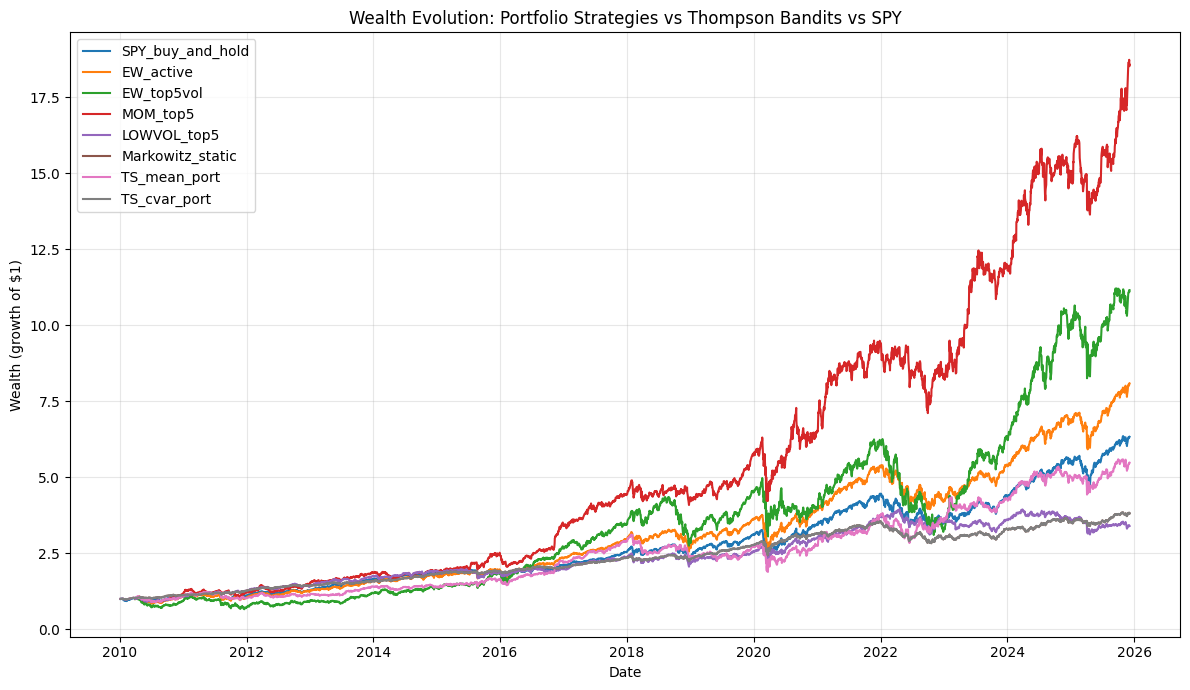

In [57]:
plt.figure(figsize=(12, 7))
strategy_series = [
    ('SPY_buy_and_hold', spy_results),
    ('EW_active', ew_active_results),
    ('EW_top5vol', ew_top5_results),
    ('MOM_top5', mom_top5_results),
    ('LOWVOL_top5', lowvol_top5_results),
    ('Markowitz_static', markowitz_results),
    ('TS_mean_port', port_ts_mean_results),
    ('TS_cvar_port', port_ts_cvar_results),
]
for label, df in strategy_series:
    df_ = df.sort_values('date').copy()
    plt.plot(df_['date'], df_['wealth'], label=label)
plt.title('Wealth Evolution: Portfolio Strategies vs Thompson Bandits vs SPY')
plt.xlabel('Date')
plt.ylabel('Wealth (growth of $1)')
# plt.yscale('log')  # uncomment if curves are very spread out
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 11. Posterior predictive checks (PPC) for selected portfolio arms

We use the Normal–Inverse-Gamma posterior for a given arm to draw posterior predictive samples, summarise the predictive distribution (mean and 5/95 percentiles), and compare against realised one-day returns for that portfolio template.

We set up a small dictionary of PPC targets and a helper function to run the checks.

1: TS_mean_port: EW_active | arm=EW_active | kind=portfolio
2: TS_mean_port: MOM_top5 | arm=MOM_top5 | kind=portfolio
3: TS_cvar_port: EW_active | arm=EW_active | kind=portfolio
4: TS_cvar_port: MOM_top5 | arm=MOM_top5 | kind=portfolio

=== PPC for target 1: TS_mean_port: EW_active (arm = EW_active, kind = portfolio) ===
Posterior predictive:
 mean: 0.0004084424131656193
 5% quantile: -0.08401501475893469
 95% quantile: 0.08498449965636544

Realised returns (portfolio 'EW_active', last 252 days):
 empirical mean: 0.0006121406751674594
 empirical std: 0.010776371324010312
 fraction below predictive 5% quantile: 0.0


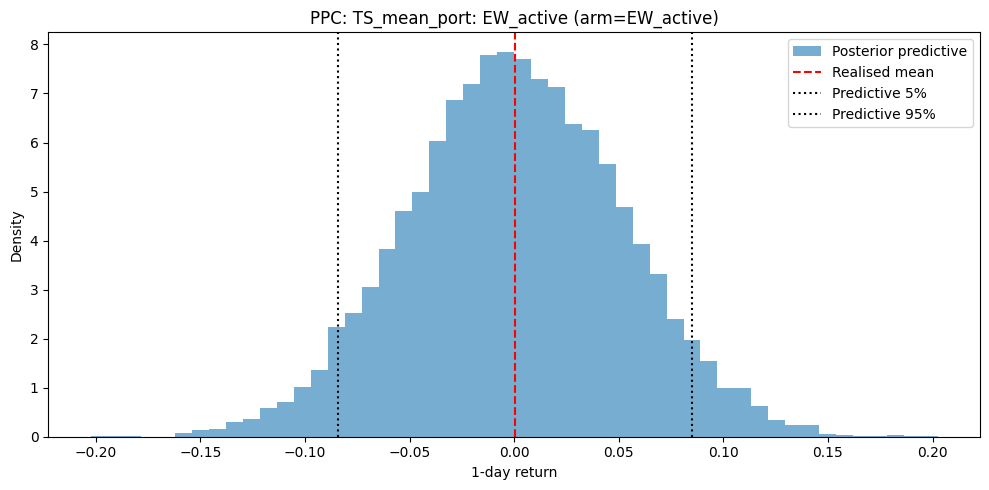


=== PPC for target 2: TS_mean_port: MOM_top5 (arm = MOM_top5, kind = portfolio) ===
Posterior predictive:
 mean: 0.0003347404318696015
 5% quantile: -0.08480690166748782
 95% quantile: 0.08560562287293602

Realised returns (portfolio 'MOM_top5', last 252 days):
 empirical mean: 0.0008273559497791908
 empirical std: 0.011403435570539201
 fraction below predictive 5% quantile: 0.0


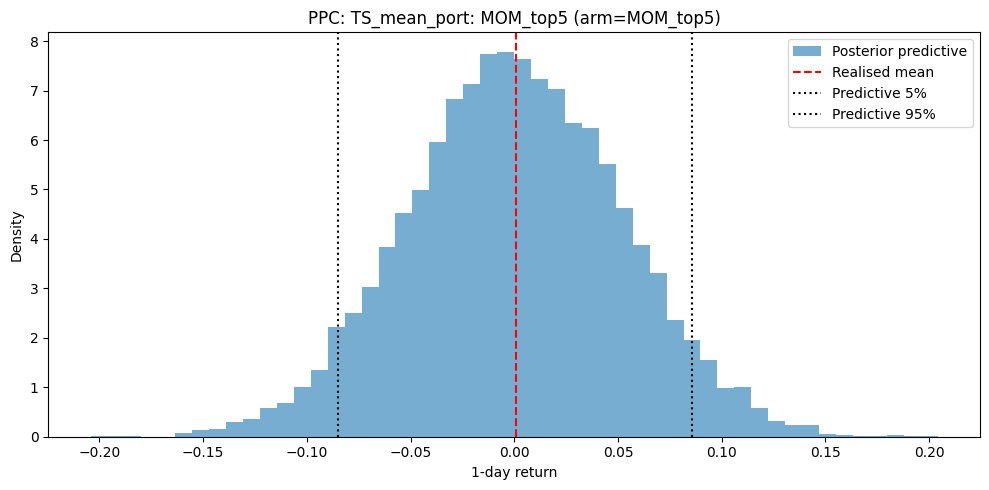

In [ ]:
def nig_posterior_params_from_stats(mu0, kappa0, alpha0, beta0, st):
    """Compute NIG posterior parameters from prior hyperparameters and sufficient stats."""
    n = st['n']
    if n == 0:
        mu_n = mu0
        kappa_n = kappa0
        alpha_n = alpha0
        beta_n = beta0
    else:
        sum_x = st['sum_x']
        sum_x2 = st['sum_x2']
        xbar = sum_x / n
        kappa_n = kappa0 + n
        mu_n = (kappa0 * mu0 + n * xbar) / kappa_n
        alpha_n = alpha0 + 0.5 * n
        sse = sum_x2 - n * (xbar ** 2)
        beta_n = (
            beta0
            + 0.5 * sse
            + (kappa0 * n * (xbar - mu0) ** 2) / (2.0 * kappa_n)
        )
    return mu_n, kappa_n, alpha_n, beta_n


def posterior_predictive_samples_nig(mu_n, kappa_n, alpha_n, beta_n,
                                     num_samples: int = 5000, rng=None):
    """Draw samples from the NIG posterior predictive for a one-day return."""
    if rng is None:
        rng = np.random.default_rng()
    gamma_samples = rng.gamma(shape=alpha_n, scale=1.0 / beta_n, size=num_samples)
    sigma2_samples = 1.0 / gamma_samples
    mu_samples = rng.normal(loc=mu_n, scale=np.sqrt(sigma2_samples / kappa_n))
    r_samples = rng.normal(loc=mu_samples, scale=np.sqrt(sigma2_samples))
    return r_samples


# PPC targets: (label, policy, arm_name)
ppc_targets = {
    1: ('TS_mean_port: EW_active', ts_mean_port_policy, 'EW_active', 'portfolio'),
    2: ('TS_mean_port: MOM_top5', ts_mean_port_policy, 'MOM_top5', 'portfolio'),
    3: ('TS_cvar_port: EW_active', ts_cvar_port_policy, 'EW_active', 'portfolio'),
    4: ('TS_cvar_port: MOM_top5', ts_cvar_port_policy, 'MOM_top5', 'portfolio'),
}
for k, (label, policy, arm_name, kind) in ppc_targets.items():
    print(f"{k}: {label} | arm={arm_name} | kind={kind}")


def run_ppc_for_index(
    k: int,
    num_samples: int = 10000,
    lookback: int = 252,
    rng_seed: int = 321,
):
    """Run a posterior predictive check for the k-th PPC target in `ppc_targets`."""
    if k not in ppc_targets:
        raise ValueError(f'PPC index {k} not in ppc_targets.')

    label, policy, arm_name, kind = ppc_targets[k]
    print(f"\n=== PPC for target {k}: {label} (arm = {arm_name}, kind = {kind}) ===")

    if arm_name not in policy.arms:
        raise ValueError(
            f"Arm '{arm_name}' not found in policy.arms. "
            'Did you run the bandit simulation before calling PPC?'
        )
    st = policy.arms[arm_name]
    mu_n, kappa_n, alpha_n, beta_n = nig_posterior_params_from_stats(
        mu0=policy.mu0,
        kappa0=policy.kappa0,
        alpha0=policy.alpha0,
        beta0=policy.beta0,
        st=st,
    )
    rng = np.random.default_rng(rng_seed)
    ppc_samples = posterior_predictive_samples_nig(
        mu_n, kappa_n, alpha_n, beta_n,
        num_samples=num_samples,
        rng=rng,
    )
    ppc_mean = np.mean(ppc_samples)
    ppc_q05 = np.quantile(ppc_samples, 0.05)
    ppc_q95 = np.quantile(ppc_samples, 0.95)
    print('Posterior predictive:')
    print(' mean:', ppc_mean)
    print(' 5% quantile:', ppc_q05)
    print(' 95% quantile:', ppc_q95)

    if kind == 'portfolio':
        realized = (
            port_returns.query('portfolio == @arm_name')
            .sort_values('date')['ret']
        )
    else:
        raise ValueError(f'Unknown kind {kind} for PPC target {k}')

    if len(realized) > lookback:
        realized = realized.tail(lookback)
    frac_below_q05 = (realized < ppc_q05).mean()
    print(f"\nRealised returns ({kind} '{arm_name}', last {len(realized)} days):")
    print(' empirical mean:', realized.mean())
    print(' empirical std:', realized.std())
    print(' fraction below predictive 5% quantile:', frac_below_q05)

    plt.figure(figsize=(10, 5))
    plt.hist(ppc_samples, bins=50, alpha=0.6, density=True, label='Posterior predictive')
    plt.axvline(realized.mean(), color='red', linestyle='--', label='Realised mean')
    plt.axvline(ppc_q05, color='black', linestyle=':', label='Predictive 5%')
    plt.axvline(ppc_q95, color='black', linestyle=':', label='Predictive 95%')
    plt.title(f'PPC: {label} (arm={arm_name})')
    plt.xlabel('1-day return')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example PPC runs
run_ppc_for_index(1)
run_ppc_for_index(2)

In [ ]:
from pathlib import Path

# ============================================================
# Results directory
# ============================================================
RESULTS_DIR = Path("../results_bandit")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
print("Saving results to:", RESULTS_DIR)

# 1. Save performance table
# ============================================================
perf_table.to_csv(RESULTS_DIR / "perf_table.csv")
print("Saved perf_table.csv")

# 2. Save wealth curves for all strategies (long format)
wealth_frames = []
for name, df in strategies.items():
    tmp = df[["date", "wealth"]].copy()
    tmp["strategy"] = name
    wealth_frames.append(tmp)

wealth_long = pd.concat(wealth_frames, ignore_index=True)
wealth_long.to_parquet(RESULTS_DIR / "wealth_curves.parquet")
wealth_long.to_csv(RESULTS_DIR / "wealth_curves.csv", index=False)
print("Saved wealth_curves.{parquet,csv}")

# 3. Choice frequencies (diagnostics)

# Asset-level TS_mean choices
asset_choice_counts_mean = (
    asset_ts_mean_results["chosen"]
    .value_counts()
    .rename_axis("ticker")
    .reset_index(name="count")
)
asset_choice_counts_mean.to_csv(
    RESULTS_DIR / "asset_ts_mean_choice_counts.csv", index=False
)
print("Saved asset_ts_mean_choice_counts.csv")

# Asset-level TS_CVaR choices
asset_choice_counts_cvar = (
    asset_ts_cvar_results["chosen"]
    .value_counts()
    .rename_axis("ticker")
    .reset_index(name="count")
)
asset_choice_counts_cvar.to_csv(
    RESULTS_DIR / "asset_ts_cvar_choice_counts.csv", index=False
)
print("Saved asset_ts_cvar_choice_counts.csv")

# Portfolio-level TS_mean choices
port_choice_counts_mean = (
    port_ts_mean_results["portfolio"]
    .value_counts()
    .rename_axis("portfolio")
    .reset_index(name="count")
)
port_choice_counts_mean.to_csv(
    RESULTS_DIR / "port_ts_mean_choice_counts.csv", index=False
)
print("Saved port_ts_mean_choice_counts.csv")

# Portfolio-level TS_CVaR choices
port_choice_counts_cvar = (
    port_ts_cvar_results["portfolio"]
    .value_counts()
    .rename_axis("portfolio")
    .reset_index(name="count")
)
port_choice_counts_cvar.to_csv(
    RESULTS_DIR / "port_ts_cvar_choice_counts.csv", index=False
)
print("Saved port_ts_cvar_choice_counts.csv")

# ============================================================
# 4. Rolling Sharpe for TS_mean_asset
# ============================================================
r = asset_ts_mean_results.set_index("date")["ret"]
window = 252
roll_mu = r.rolling(window).mean() * 252
roll_sigma = r.rolling(window).std() * np.sqrt(252)
roll_sharpe = (roll_mu / roll_sigma).dropna()

roll_sharpe.to_csv(
    RESULTS_DIR / "asset_ts_mean_rolling_sharpe_252d.csv",
    header=["rolling_sharpe"]
)
print("Saved asset_ts_mean_rolling_sharpe_252d.csv")

# ============================================================
# 5. Save key equity curve figures as PNG
# ============================================================

# 5.1 TS_mean_asset vs SPY
plt.figure(figsize=(10, 6))
plt.plot(ts_equity.index, ts_equity, label="TS_mean_asset")
plt.plot(spy_equity.index, spy_equity, label="SPY buy & hold")
plt.title("Wealth evolution: TS_mean_asset vs SPY")
plt.xlabel("Date")
plt.ylabel("Wealth")
plt.legend()
plt.tight_layout()
plt.savefig(RESULTS_DIR / "equity_ts_mean_asset_vs_spy.png", dpi=200)
plt.close()

# 5.2 Asset vs portfolio bandits vs SPY
plt.figure(figsize=(10, 6))
plt.plot(port_ts_mean_results["date"], port_ts_mean_results["wealth"],
         label="TS_mean_port")
plt.plot(ts_equity.index, ts_equity, label="TS_mean_asset", alpha=0.7)
plt.plot(spy_equity.index, spy_equity, label="SPY", alpha=0.7)
plt.title("Wealth evolution: asset vs portfolio bandits vs SPY")
plt.xlabel("Date")
plt.ylabel("Wealth")
plt.legend()
plt.tight_layout()
plt.savefig(RESULTS_DIR / "equity_asset_vs_port_vs_spy.png", dpi=200)
plt.close()

# 5.3 All portfolio strategies + TS_mean_port + TS_cvar_port + SPY
plt.figure(figsize=(12, 7))
strategy_series = [
    ("SPY_buy_and_hold", spy_results),
    ("EW_active",        ew_active_results),
    ("EW_top5vol",       ew_top5_results),
    ("MOM_top5",         mom_top5_results),
    ("TS_mean_port",     port_ts_mean_results),
    ("TS_cvar_port",     port_ts_cvar_results),
]
for label, df in strategy_series:
    df_ = df.sort_values("date").copy()
    plt.plot(df_["date"], df_["wealth"], label=label)

plt.title("Wealth Evolution: Portfolio Strategies vs Thompson Bandits vs SPY")
plt.xlabel("Date")
plt.ylabel("Wealth (growth of $1)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(RESULTS_DIR / "equity_all_portfolio_strategies.png", dpi=200)
plt.close()

print("Saved equity curve figures")

# ============================================================
# 6. Posterior predictive checks – numerical summaries
# ============================================================

def ppc_summary_for_index(
    k: int,
    num_samples: int = 10000,
    lookback: int = 252,
    rng_seed: int = 321,
):
    """
    Numerical-only version of run_ppc_for_index(k):
    returns a dict with predictive & realised summaries, no plotting.
    """
    if k not in ppc_targets:
        raise ValueError(f"PPC index {k} not in ppc_targets.")

    label, policy, arm_name, kind = ppc_targets[k]

    if arm_name not in policy.arms:
        raise ValueError(
            f"Arm '{arm_name}' not found in policy.arms. "
            "Did you run the bandit simulation before calling PPC?"
        )

    st = policy.arms[arm_name]

    mu_n, kappa_n, alpha_n, beta_n = nig_posterior_params_from_stats(
        mu0=policy.mu0,
        kappa0=policy.kappa0,
        alpha0=policy.alpha0,
        beta0=policy.beta0,
        st=st,
    )

    rng = np.random.default_rng(rng_seed)
    ppc_samples = posterior_predictive_samples_nig(
        mu_n, kappa_n, alpha_n, beta_n,
        num_samples=num_samples,
        rng=rng,
    )

    ppc_mean = float(np.mean(ppc_samples))
    ppc_q05 = float(np.quantile(ppc_samples, 0.05))
    ppc_q95 = float(np.quantile(ppc_samples, 0.95))

    # Realised returns
    if kind == "asset":
        realized = (
            returns_long.query("ticker == @arm_name")
            .sort_values("date")["ret"]
        )
    elif kind == "portfolio":
        realized = (
            port_returns.query("portfolio == @arm_name")
            .sort_values("date")["ret"]
        )
    else:
        raise ValueError(f"Unknown kind '{kind}' for PPC target {k}")

    if len(realized) > lookback:
        realized = realized.tail(lookback)

    frac_below_q05 = float((realized < ppc_q05).mean())
    realized_mean = float(realized.mean())
    realized_std = float(realized.std())

    return {
        "ppc_index": k,
        "label": label,
        "arm_name": arm_name,
        "kind": kind,
        "ppc_mean": ppc_mean,
        "ppc_q05": ppc_q05,
        "ppc_q95": ppc_q95,
        "realized_mean": realized_mean,
        "realized_std": realized_std,
        "realized_n": int(len(realized)),
        "frac_below_ppc_q05": frac_below_q05,
    }

ppc_summaries = []
for k in sorted(ppc_targets.keys()):
    ppc_summaries.append(ppc_summary_for_index(k))

ppc_df = pd.DataFrame(ppc_summaries)
ppc_df.to_csv(RESULTS_DIR / "ppc_summaries.csv", index=False)
print("Saved ppc_summaries.csv")

# ============================================================
# 7. Posterior predictive figures (optional, similar to run_ppc_for_index)
# ============================================================

for k in sorted(ppc_targets.keys()):
    label, policy, arm_name, kind = ppc_targets[k]
    print(f"Plotting PPC figure for index {k}: {label}")

    st = policy.arms[arm_name]
    mu_n, kappa_n, alpha_n, beta_n = nig_posterior_params_from_stats(
        mu0=policy.mu0,
        kappa0=policy.kappa0,
        alpha0=policy.alpha0,
        beta0=policy.beta0,
        st=st,
    )

    rng = np.random.default_rng(123)
    ppc_samples = posterior_predictive_samples_nig(
        mu_n, kappa_n, alpha_n, beta_n,
        num_samples=10000,
        rng=rng,
    )

    if kind == "asset":
        realized = (
            returns_long.query("ticker == @arm_name")
            .sort_values("date")["ret"]
        )
    else:
        realized = (
            port_returns.query("portfolio == @arm_name")
            .sort_values("date")["ret"]
        )

    realized = realized.tail(252)

    ppc_q05 = np.quantile(ppc_samples, 0.05)
    ppc_q95 = np.quantile(ppc_samples, 0.95)

    plt.figure(figsize=(10, 5))
    plt.hist(ppc_samples, bins=50, alpha=0.6, density=True,
             label="Posterior predictive")
    plt.axvline(realized.mean(), color="red", linestyle="--",
                label="Realised mean")
    plt.axvline(ppc_q05, color="black", linestyle=":",
                label="Predictive 5%")
    plt.axvline(ppc_q95, color="black", linestyle=":",
                label="Predictive 95%")

    plt.title(f"PPC: {label} (arm={arm_name})")
    plt.xlabel("1-day return")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / f"ppc_{k}_{arm_name}.png", dpi=200)
    plt.close()

print("Saved PPC figures")
